In [92]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np

In [93]:
import json, urllib.request

# Open and read the JSON file
with urllib.request.urlopen('https://raw.githubusercontent.com/hamidrezavalidi/IE3311_5318_Project_Fall2024/refs/heads/main/Data/Quant_Masters.json') as url:
    data = json.load(url)
len(data)

724

In [94]:
import networkx as nx

# Create a graph
G = nx.DiGraph()

# Create nodes
counter = 0
for element in data:
    G.add_nodes_from([(counter, element)])
    counter += 1

#Create donor-recipient compatibility table
donor_recipient_compatibility = {'O': ['O', 'A', 'B', 'AB'], 'A': ['A', 'AB'], 'B':['B', 'AB'], 'AB':['AB']}

# Create edges
for node in G.nodes:
    donors = G.nodes[node]['Donor']
    for donor in donors:
        for vertex in G.nodes:
            if node == vertex: continue
            recipient = G.nodes[vertex]['Recipient']
            if recipient not in donor_recipient_compatibility[donor]: continue
            G.add_edge(node, vertex)    

In [97]:
# Find a maximum matching with cycles size is 2
import gurobipy as gp
from gurobipy import GRB

# Create model object
m = gp.Model()

# Create variable for each edge
x = m.addVars(G.edges, vtype=GRB.BINARY)

# Objective function: maximize number of edges
m.setObjective(gp.quicksum(x[e] for e in G.edges), GRB.MAXIMIZE)

# The number of incomming arcs to each vertex is at most one
m.addConstrs(gp.quicksum(x[(u,v)] for u in G.neighbors(v) if (u,v) in G.edges) <= 1 for v in G.nodes)

# The number of incomming arcs should be equal to the number of outgoing arcs
m.addConstrs(gp.quicksum(x[(u,v)] for u in G.neighbors(v) if (u,v) in G.edges) == gp.quicksum(x[(v,u)] for u in G.neighbors(v) if (v,u) in G.edges) for v in G.nodes)

# The cycles size is 2
for v in G.nodes:
    for u in G.neighbors(v):
        if(u,v) in G.edges:
            if(v,u) in G.edges:
                m.addConstr(x[(u,v)] == x[(v,u)])

# Solve
m.optimize()

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: AMD Ryzen 7 5700U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 69016 rows, 174793 columns and 445065 nonzeros
Model fingerprint: 0x584eb3d6
Variable types: 0 continuous, 174793 integer (174793 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 68646 rows and 141009 columns
Presolve time: 0.11s
Presolved: 370 rows, 33784 columns, 67568 nonzeros
Variable types: 0 continuous, 33784 integer (33784 binary)

Starting sifting (using dual simplex for sub-problems)...

    Iter     Pivots    Primal Obj      Dual Obj        Time
       0          0     infinity     -7.3800000e+02      0s
       1        439  -2.200000

In [98]:
# Display the solution
for e in G.edges:
    if x[e].X > 0.5:
        print(e) 

(2, 561)
(10, 366)
(14, 175)
(18, 474)
(21, 251)
(23, 261)
(25, 253)
(29, 435)
(31, 371)
(32, 42)
(33, 83)
(36, 409)
(40, 139)
(42, 32)
(43, 712)
(45, 407)
(47, 677)
(49, 588)
(53, 619)
(56, 696)
(58, 633)
(64, 475)
(66, 380)
(70, 514)
(73, 694)
(75, 119)
(78, 462)
(81, 128)
(83, 33)
(86, 300)
(87, 278)
(95, 292)
(98, 229)
(100, 425)
(101, 111)
(103, 279)
(104, 131)
(107, 413)
(111, 101)
(112, 691)
(114, 718)
(116, 600)
(117, 367)
(119, 75)
(120, 346)
(122, 186)
(127, 401)
(128, 81)
(130, 350)
(131, 104)
(132, 335)
(134, 173)
(136, 218)
(138, 574)
(139, 40)
(141, 659)
(144, 702)
(146, 232)
(148, 557)
(151, 301)
(153, 398)
(154, 372)
(156, 180)
(157, 433)
(159, 480)
(160, 233)
(161, 626)
(162, 568)
(165, 270)
(168, 387)
(171, 298)
(172, 683)
(173, 134)
(175, 14)
(179, 296)
(180, 156)
(181, 203)
(182, 316)
(185, 661)
(186, 122)
(187, 364)
(188, 546)
(191, 719)
(192, 230)
(193, 563)
(195, 294)
(199, 609)
(200, 472)
(202, 640)
(203, 181)
(204, 581)
(205, 395)
(210, 226)
(211, 592)
(215, 69

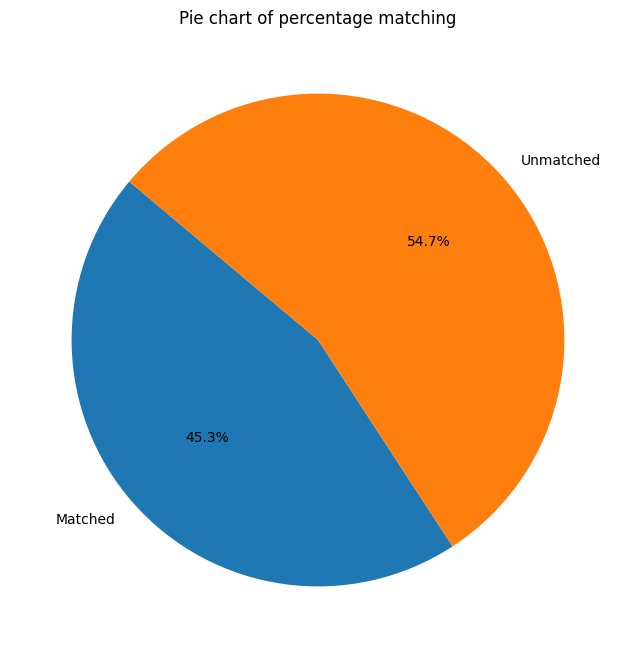

In [79]:
# Pie chart of percentage of matching 
import matplotlib.pyplot as plt

labels = ['Matched', 'Unmatched']
matched = (m.objVal)/len(data)
unmactched = 1 - matched
sizes = [matched, unmactched]

# Creating the pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Pie chart of percentage matching')
plt.show()


In [80]:
donor_count =[]
for element in range(len(data)):
    donor_count.append(len(data[element]['Donor']))

In [81]:
node_results = {}
for node in G.nodes:
    node_results[node] = 0
for e in G.edges:
    u, v = e
    if x[e].X > 0.5:
        node_results[u] = 1
        node_results[v] = 1
result = []
for i in range(len(node_results)): result.append(node_results[i])

In [82]:
import pandas as pd

# Create a DataFrame
data1 = pd.DataFrame({'donor_count': donor_count, 'result': result})

# Create a pivot table showing the percentage of each result (0 and 1) for each category
pivot_table = data1.pivot_table(index='donor_count', columns='result', aggfunc='size', fill_value=0)

# Calculate percentages for each category
pivot_table_percentage = pivot_table.div(pivot_table.sum(axis=1), axis=0) * 100

# Rename columns for better understanding
pivot_table_percentage.columns = ['Percentage of Unmatched', 'Percentage of Matched']
print(pivot_table)
print(pivot_table_percentage)

result         0    1
donor_count          
1            155   91
2            150  237
3             91    0
             Percentage of Unmatched  Percentage of Matched
donor_count                                                
1                           63.00813               36.99187
2                           38.75969               61.24031
3                          100.00000                0.00000


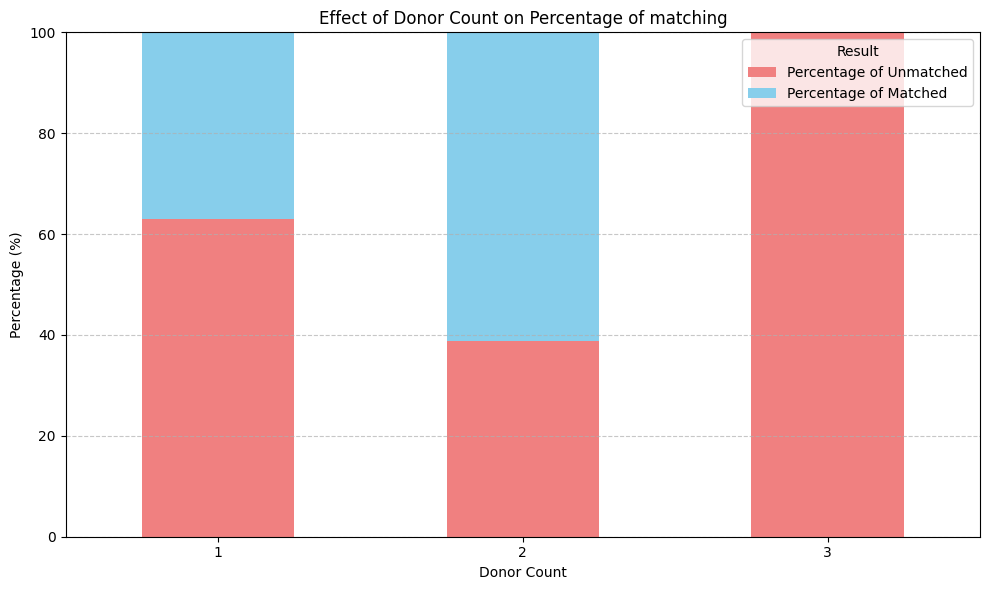

In [83]:
plt.figure(figsize=(10, 6))
pivot_table_percentage.plot(kind='bar', stacked=True, color=['lightcoral', 'skyblue'], ax=plt.gca())
plt.title('Effect of Donor Count on Percentage of matching')
plt.xlabel('Donor Count')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=0)
plt.ylim(0, 100)
plt.legend(title='Result', loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the chart
plt.tight_layout()
plt.show()

In [84]:
# Find cycles of length 3

potential_cycle_3 = []

H = G.to_undirected()

for (u,v) in H.edges:
    for k in nx.common_neighbors(H, u, v):
        potential_cycle_3.append((u,v,k))
              
        
cycle_3 = [] 

for (u,v,k) in potential_cycle_3:
    if (u,v) in G.edges and (v,k) in G.edges and (k,u) in G.edges:
        cycle_3.append((u,v,k,u))
    if (v,u) in G.edges and (u,k) in G.edges and (k,v) in G.edges: 
        cycle_3.append((v,u,k,v))

print("cycle_3:", cycle_3) 

cycle_3: []


In [85]:
# Find cycles of length 3 with Depth First Search method
def dfs_find_3_cycles(G, start, current, path, visited, cycles):
    path.append(current)
    visited[current] = True
    
    for neighbor in G.successors(current):
        if neighbor == start and len(path) == 3:
            # Store cycles of exactly 3 nodes
            cycles.append(path.copy())
        elif neighbor not in visited or not visited[neighbor]:
            if len(path) < 3:  # Only proceed if path size is less than 3
                dfs_find_3_cycles(G, start, neighbor, path, visited, cycles)

    path.pop()
    visited[current] = False

def find_3_cycles(G):
    cycles = []
    
    for node in G.nodes:
        visited = {n: False for n in G.nodes}
        dfs_find_3_cycles(G, node, node, [], visited, cycles)
    
    # Remove duplicate cycles
    unique_cycles = []
    for cycle in cycles:
        sorted_cycle = sorted(cycle)
        if sorted_cycle not in [sorted(c) for c in unique_cycles]:
            unique_cycles.append(cycle)
    
    return unique_cycles


cycles = find_3_cycles(G)
print("All detected cycles:", cycles)

All detected cycles: []
